## Import library files

In [2]:
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
import os
import joblib

## Load data

In [3]:
# Define the relative path from the 'notebooks' folder to 'data/raw/'
data_path = os.path.join("..", "data", "raw", "supervised_accident_data.csv")

# Load the dataset
df = pd.read_csv(data_path)
display(df.head()) # Show first 3 rows
print(df.shape)

,Accident Report,Primary Cause,Secondary Cause,Risk Factor
0,"On 12 Jan 2024, at 08:50 AM, under heavy rain ...",Wrong side driving,Wrong Lane Violation,High
1,"On 02 Sep 2024, at 08:48 AM, under clear condi...",Red light jumping,Signal Violation,Low
2,"On 22 Feb 2024, at 08:22 PM, under heavy rain ...",Tailgating,Tailgating Violation,High
3,"On 08 Mar 2023, at 06:53 PM, under heavy rain ...",Over-speeding,Speeding Violation,High
4,"On 11 Jul 2023, at 03:41 PM, under drizzle con...",Distracted driving,Mobile Phone Violation,Low


(20000, 4)


## Check for duplicates and missing values

In [4]:
print(df.isnull().sum())
print(df.duplicated().sum())

Accident Report    0
Primary Cause      0
Secondary Cause    0
Risk Factor        0
dtype: int64
0


# Check the distribution of the 'Primary cause' column

C:\Users\Jyothy\AppData\Local\Temp\ipykernel_26364\4144102907.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Primary Cause', data=df, palette='viridis')


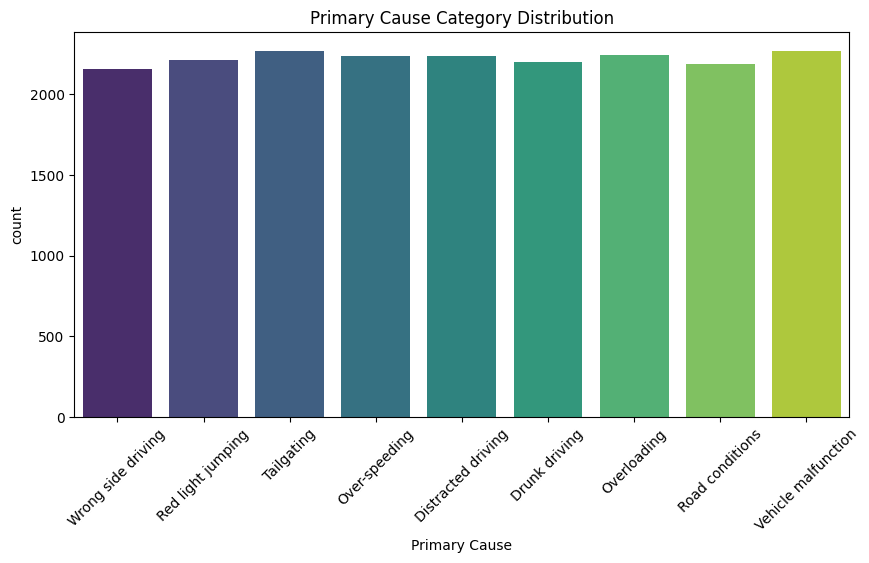

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.countplot(x='Primary Cause', data=df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Primary Cause Category Distribution')
plt.show()


### There is no data imbalance

C:\Users\Jyothy\AppData\Local\Temp\ipykernel_26364\705571202.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Secondary Cause', data=df, palette='viridis')


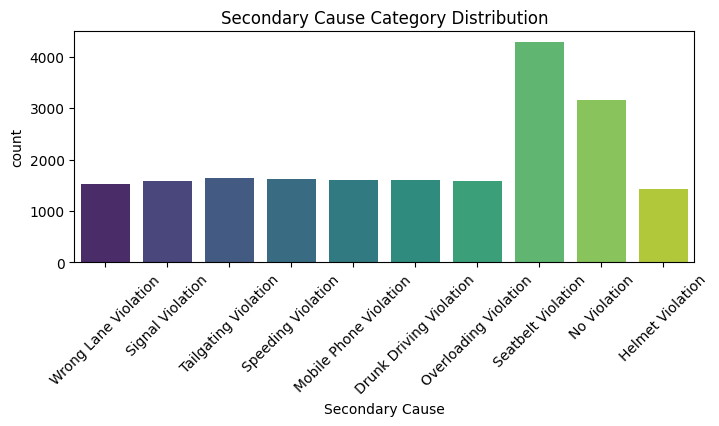

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
sns.countplot(x='Secondary Cause', data=df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Secondary Cause Category Distribution')
plt.show()

C:\Users\Jyothy\AppData\Local\Temp\ipykernel_26364\2900823562.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Risk Factor', data=df, palette='viridis')


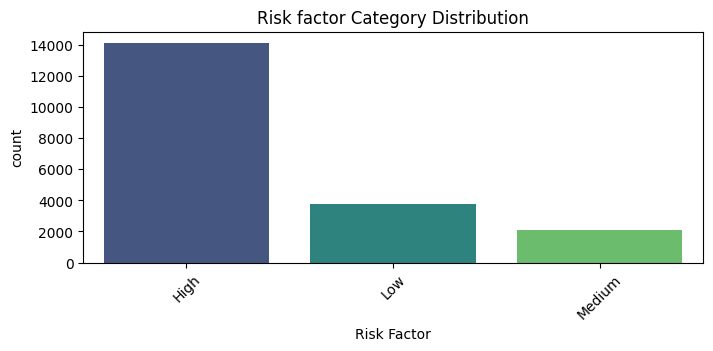

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
sns.countplot(x='Risk Factor', data=df, palette='viridis')
plt.xticks(rotation=45)
plt.title('Risk factor Category Distribution')
plt.show()

# NLP Text cleaning

In [8]:
nlp= spacy.load("en_core_web_sm")
# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    doc = nlp(text)
    words = [token.lemma_.lower() for token in doc if token.text.lower() not in stopwords.words('english')]
    return " ".join(words)


In [9]:
# Apply text preprocessing
df['Processed Report'] = df['Accident Report'].apply(preprocess_text)

# Display sample data
display(df.head())


,Accident Report,Primary Cause,Secondary Cause,Risk Factor,Processed Report
0,"On 12 Jan 2024, at 08:50 AM, under heavy rain ...",Wrong side driving,Wrong Lane Violation,High,12 jan 2024 0850 heavy rain condition truck co...
1,"On 02 Sep 2024, at 08:48 AM, under clear condi...",Red light jumping,Signal Violation,Low,02 sep 2024 0848 clear condition car collide b...
2,"On 22 Feb 2024, at 08:22 PM, under heavy rain ...",Tailgating,Tailgating Violation,High,22 feb 2024 0822 pm heavy rain condition truck...
3,"On 08 Mar 2023, at 06:53 PM, under heavy rain ...",Over-speeding,Speeding Violation,High,08 mar 2023 0653 pm heavy rain condition car c...
4,"On 11 Jul 2023, at 03:41 PM, under drizzle con...",Distracted driving,Mobile Phone Violation,Low,11 jul 2023 0341 pm drizzle condition autorick...


In [10]:
cleaned_data_path= os.path.join("..", "data", "raw", "cleaned_processed_data.csv")
df.to_csv(cleaned_data_path, index=False)
df = pd.read_csv(cleaned_data_path)
display(df.head())

,Accident Report,Primary Cause,Secondary Cause,Risk Factor,Processed Report
0,"On 12 Jan 2024, at 08:50 AM, under heavy rain ...",Wrong side driving,Wrong Lane Violation,High,12 jan 2024 0850 heavy rain condition truck co...
1,"On 02 Sep 2024, at 08:48 AM, under clear condi...",Red light jumping,Signal Violation,Low,02 sep 2024 0848 clear condition car collide b...
2,"On 22 Feb 2024, at 08:22 PM, under heavy rain ...",Tailgating,Tailgating Violation,High,22 feb 2024 0822 pm heavy rain condition truck...
3,"On 08 Mar 2023, at 06:53 PM, under heavy rain ...",Over-speeding,Speeding Violation,High,08 mar 2023 0653 pm heavy rain condition car c...
4,"On 11 Jul 2023, at 03:41 PM, under drizzle con...",Distracted driving,Mobile Phone Violation,Low,11 jul 2023 0341 pm drizzle condition autorick...


# Convert Text into Numeric Features(Vectors)
#### TF-IDF vectorization|

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Limit features for efficiency
X = vectorizer.fit_transform(df['Processed Report'])

# Save vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

# Label encoding targets

In [12]:
# Encode target labels
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder_primary = LabelEncoder()
y_primary = label_encoder_primary.fit_transform(df['Primary Cause'])

label_encoder_secondary = LabelEncoder()
y_secondary = label_encoder_secondary.fit_transform(df['Secondary Cause'])

label_encoder_risk = LabelEncoder()
y_risk = label_encoder_risk.fit_transform(df['Risk Factor'])

# Save encoders
joblib.dump(label_encoder_primary, 'label_encoder_primary.pkl')
joblib.dump(label_encoder_secondary, 'label_encoder_secondary.pkl')
joblib.dump(label_encoder_risk, 'label_encoder_risk.pkl')

# Display encoded values
print('Encoded primary cause classes are:',label_encoder_primary.classes_)  # Shows mapping of classes
print('Encoded secondary cause classes are:',label_encoder_secondary.classes_)  # Shows mapping of classes
print('Encoded risk factors are:',label_encoder_risk.classes_)  # Shows mapping of classes

Encoded primary cause classes are: ['Distracted driving' 'Drunk driving' 'Over-speeding' 'Overloading'
 'Red light jumping' 'Road conditions' 'Tailgating' 'Vehicle malfunction'
 'Wrong side driving']
Encoded secondary cause classes are: ['Drunk Driving Violation' 'Helmet Violation' 'Mobile Phone Violation'
 'No Violation' 'Overloading Violation' 'Seatbelt Violation'
 'Signal Violation' 'Speeding Violation' 'Tailgating Violation'
 'Wrong Lane Violation']
Encoded risk factors are: ['High' 'Low' 'Medium']


# Save 'X' and 'y_primary'

In [13]:
import numpy as np

# Save sparse matrix
np.savez_compressed("X_sparse.npz", data=X.data, indices=X.indices, indptr=X.indptr, shape=X.shape)

print("Saved X_sparse.npz successfully!")


Saved X_sparse.npz successfully!


In [14]:
print(type(y_primary))
print(y_primary.ndim)

<class 'numpy.ndarray'>
1


In [15]:
pd.Series(y_primary).to_csv("y_primary.csv", index=False)
pd.Series(y_secondary).to_csv("y_secondary.csv", index=False)
pd.Series(y_risk).to_csv("y_risk.csv", index=False)